In [1]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning

from sklearn import metrics

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))
plot_path = PATH / "plots" / "s_unbalance"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [3]:
%%time
tiles = ["b234", "b360", "b278", "b261"]
all_results = joblib.load("_cache/unbalanced_diff_2.pkl")

CPU times: user 262 ms, sys: 1.43 s, total: 1.69 s
Wall time: 4 s


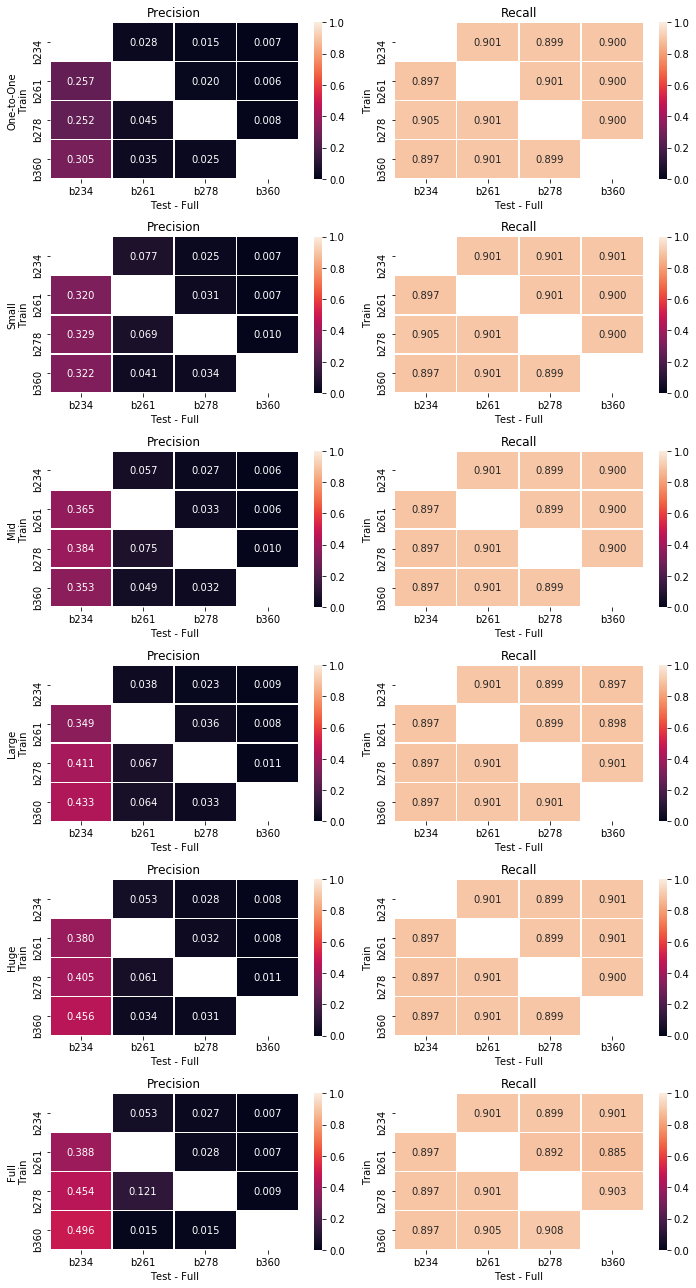

In [4]:
def as_df(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Train": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Train")[tiles]
    return df

def heatmap(ax, results, fp):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(recalls, fp)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
        
    fix_precs = as_df(fix_precs)
    fix_recall = as_df(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test - Full")
    ax[0].set_title(u"Precision".format(fp))
    
    sns.heatmap(fix_recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test - Full")
    ax[1].set_title(u"Recall".format(fp))

fig, axes = plt.subplots(len(all_results), 2, figsize=(10, 3*len(all_results)))

for rname, axs in zip(all_results, axes):
    heatmap(axs, all_results[rname], 0.90)
    axs[0].set_ylabel(f"{rname}\n{axs[0].get_ylabel()}")
    
fig.tight_layout()
fig.savefig(plot_path / "section_unbalanced_diffsize_prec_rec_heatmap_2.pdf")

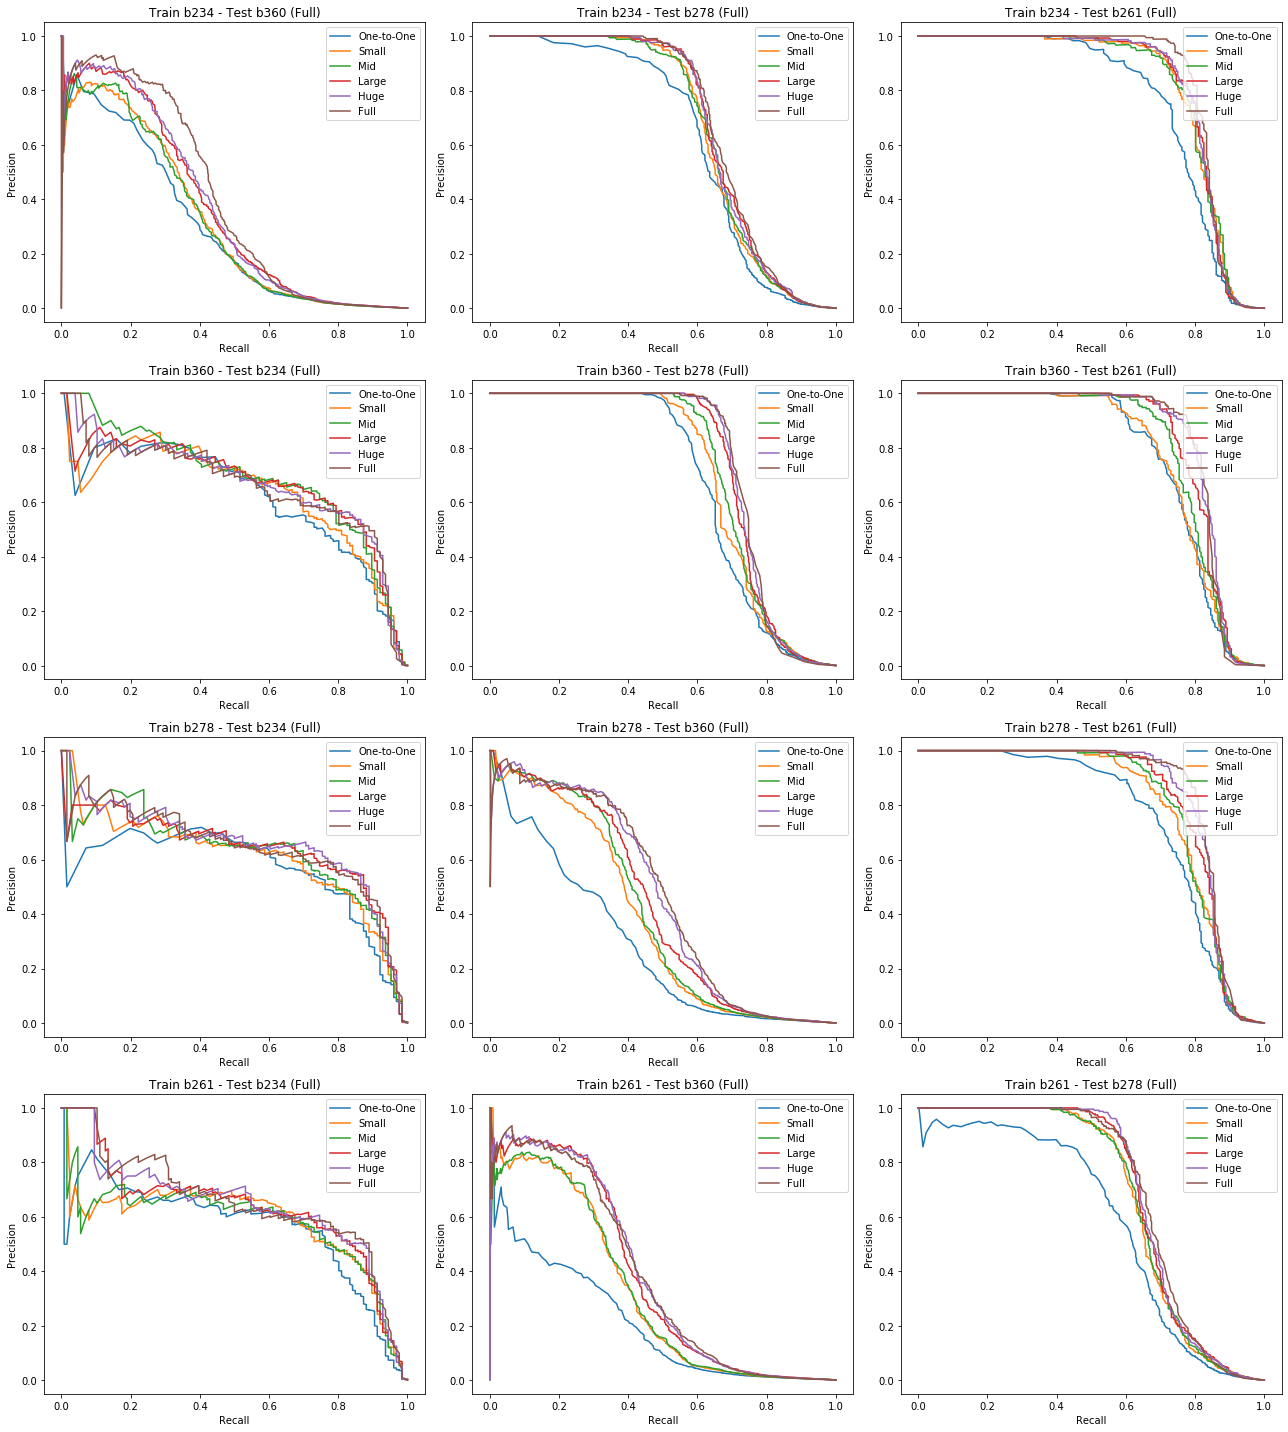

In [5]:
def plot_prec_roc_curve(ax, train_name, test_name, all_results):
    for rname, results in all_results.items():
        for r in results:
            if r.test_name == test_name and r.train_name == train_name:
                ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=rname)
                break
    ax.set_title("Train {} - Test {} (Full)".format(train_name, test_name))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc='upper right')

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = it.chain(*axes)
for train_name in tiles:
    for test_name in tiles:
        if train_name == test_name:
            continue
        ax = next(axes)
        plot_prec_roc_curve(ax, train_name, test_name, all_results)
fig.tight_layout()
fig.savefig(plot_path  / "section_unbalanced_diffsize_prec_rec_curve_2.pdf")

In [6]:
import datetime
datetime.datetime.now()

datetime.datetime(2020, 1, 23, 13, 8, 46, 696819)